In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# -------------------------------------------------------
# User/Market Information - Update before running
# -------------------------------------------------------

# Income and Starting Balance
pre_tax_annual_income = 125000
starting_balance = 10000

# Brokerage
percentage_contribution_brokerage = 0.14

# Roth 401k
percentage_contribution_roth = 0.06
employer_match_brackets = [0.01, 0.06]
employer_match_rates = [1, 0.5, 0]

# Market, Pay, and Savings Growth Rates
contribution_growth_rate = 0.03
annual_raise = 0.04
market_growth_rate = 0.08

# Age and Marital Status
current_age = 23
retirement_age = 50
married = True

# Federal Tax Rates
tax_brackets = [11925, 48475, 103350, 197300, 250525, 626350]
tax_rates = [0.10, 0.12, 0.22, 0.24, 0.32, 0.35, 0.37]

# Capital Gains Tax Rates
gains_brackets_single = [48350, 533400]
gains_brackets_married = [96700, 600050]
gains_rates = [0.10, 0.15, 0.20]

# Market Noise
market_noise = True
market_cycle_time = 8   # Time in years
market_cycle_strength = 0.12
market_cycle_seed = 0   # 0 to start when entering boom, 13 to start when entering recession
market_fluctuation_strength = 0.15

In [2]:
# Tax functions
def calculate_post_tax_income(income):
    return helper_post_tax_income(income, 0)
    
def helper_post_tax_income(income, i):
    if(i > len(tax_brackets) - 1 or income < tax_brackets[i]):
        return (1 - tax_rates[i]) * income
    return (1 - tax_rates[i]) * tax_brackets[i] + helper_post_tax_income(income - tax_brackets[i], i + 1)

# Capital gains functions
def calculate_post_capital_gains_income(income):
    brokerage_rate = percentage_contribution_brokerage / (percentage_contribution_brokerage + calculate_employer_contribution(percentage_contribution_roth))
    return helper_post_capital_gains_income(income * brokerage_rate, 0) + (income * (1 - brokerage_rate))

def helper_post_capital_gains_income(income, i):
    if(married == False):
        if(i > len(gains_brackets_single) - 1 or income < gains_brackets_single[i]):
            return (1 - gains_rates[i]) * income
        return (1 - gains_rates[i]) * gains_brackets_single[i] + helper_post_capital_gains_income(income - gains_brackets_single[i], i + 1)
    if(i > len(gains_brackets_married) - 1 or income < gains_brackets_married[i]):
        return (1 - gains_rates[i]) * income
    return (1 - gains_rates[i]) * gains_brackets_married[i] + helper_post_capital_gains_income(income - gains_brackets_married[i], i + 1)

# Employer contribution functions
def calculate_employer_contribution(percentage_contribution):
    return helper_employer_contribution(percentage_contribution, 0)

def helper_employer_contribution(percentage_contribution, i):
    if(i > len(employer_match_brackets) - 1 or percentage_contribution < employer_match_brackets[i]):
        return (1 + employer_match_rates[i]) * percentage_contribution
    return (1 + employer_match_rates[i]) * employer_match_brackets[i] + helper_employer_contribution(percentage_contribution - employer_match_brackets[i], i + 1)

# Adjust tax, capital gains, and employer match brackets for calculation
for i in range(len(tax_brackets) - 1, 0, -1):
    tax_brackets[i] -= tax_brackets[i-1]
for i in range(len(gains_brackets_single) - 1, 0, -1):
    gains_brackets_single[i] -= gains_brackets_single[i-1]
    gains_brackets_married[i] -= gains_brackets_married[i-1]
for i in range(len(employer_match_brackets) - 1, 0, -1):
    employer_match_brackets[i] -= employer_match_brackets[i-1]

# Calculate post-tax income
post_tax_annual_income = calculate_post_tax_income(pre_tax_annual_income)

# Arrays and starting values
balance_all = [starting_balance] * 26 * (retirement_age - current_age)
balance_income = [starting_balance] * 26 * (retirement_age - current_age)
starting_capital = [starting_balance] * 26 * (retirement_age - current_age)
contribution_amount = [calculate_post_tax_income(pre_tax_annual_income) * (percentage_contribution_brokerage + calculate_employer_contribution(percentage_contribution_roth)) / 26] * 26 * (retirement_age - current_age)
contribution_amount_no_match = [calculate_post_tax_income(pre_tax_annual_income) * (percentage_contribution_brokerage + percentage_contribution_roth) / 26] * 26 * (retirement_age - current_age)
savings_percentage_brokerage = [percentage_contribution_brokerage] * 26 * (retirement_age - current_age)
savings_percentage_roth = [percentage_contribution_roth] * 26 * (retirement_age - current_age)
temp_market_rate = market_growth_rate
age_interest_exceed_income = -1

# Create array for market noise
if(market_noise == True):
    temp_market_rate = market_growth_rate + market_cycle_strength * math.sin(market_cycle_seed * 26 * math.pi / market_cycle_time / 13)
market_rate = [temp_market_rate] * 26 * (retirement_age - current_age)

# Print initial post-tax income
print("Initial Post-Tax Annual Income: \033[1m" + str(post_tax_annual_income) + "\033[0m")

Initial Post-Tax Annual Income: 102153.0


In [3]:
# Run market simulation
tail_index = (retirement_age - current_age) * 26
for i in range(1, tail_index):
    
    # Calculate post-tax income
    post_tax_income = calculate_post_tax_income(pre_tax_annual_income * (1 + annual_raise) ** int(i / 26))
    
    # Determine contributions
    current_percentage_roth = round(percentage_contribution_roth * (1 + contribution_growth_rate) ** int(i / 26), 2)
    current_percentage_brokerage = round(percentage_contribution_brokerage * (1 + contribution_growth_rate) ** int(i / 26), 2)
    contribution = post_tax_income * (current_percentage_brokerage + calculate_employer_contribution(current_percentage_roth)) / 26
    contribution_no_match = post_tax_income * (current_percentage_brokerage + current_percentage_roth) / 26

    # Determine market growth - Used in noisy market
    market_growth = market_growth_rate
    if(market_noise == True):
        market_growth = market_growth_rate + market_cycle_strength * math.sin((market_cycle_seed * 26 + i) * math.pi / market_cycle_time / 13) +  np.random.normal(0, market_fluctuation_strength)
    
    # Update balances
    balance_all[i] = balance_all[i-1] * (1 + market_growth / 365) ** 14 + contribution
    balance_income[i] = balance_income[i-1] + contribution

    # Update contributions
    contribution_amount[i] = contribution
    contribution_amount_no_match[i] = contribution_no_match

    # Update savings percentage
    savings_percentage_brokerage[i] = current_percentage_brokerage
    savings_percentage_roth[i] = current_percentage_roth

    # Update market rate
    market_rate[i] = market_growth

    # Check if investment interest exceeds income
    if(age_interest_exceed_income == -1 and balance_all[i] - balance_all[i-1] - contribution > post_tax_income / 13):
        age_interest_exceed_income = int(i/26) + current_age

# Calculate maximum retirement withdrawal
retirement_withdrawal_max = balance_all[tail_index - 1] * (1 + market_growth_rate / 365) ** 30 - balance_all[tail_index - 1]
post_capital_gains_withdrawal_max = calculate_post_capital_gains_income(retirement_withdrawal_max * 12) / 12

# Calculate safe retirement withdrawal using 4% rule
retirement_withdrawal_safe = balance_all[tail_index - 1] * 0.04 / 12
post_capital_gains_withdrawal_safe = calculate_post_capital_gains_income(retirement_withdrawal_safe * 12) / 12

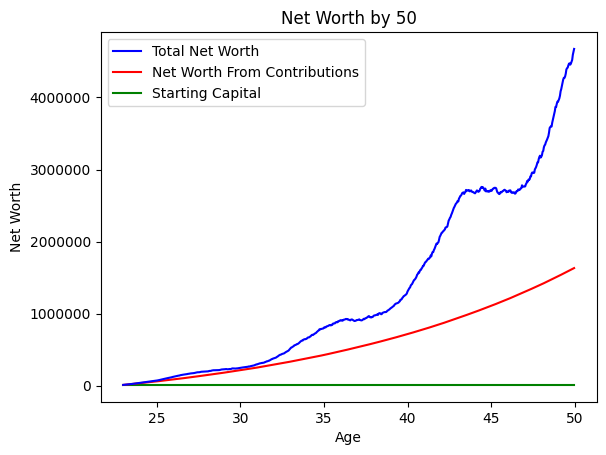

Safe monthly withdrawal after retirement using 4% rule: 15581.15
After capital gains tax: 14591.71

Maximum monthly withdrawal after retirement to maintin net worth: 30833.29
After capital gains tax: 28480.9

Age that investment interest exceeds income: 34


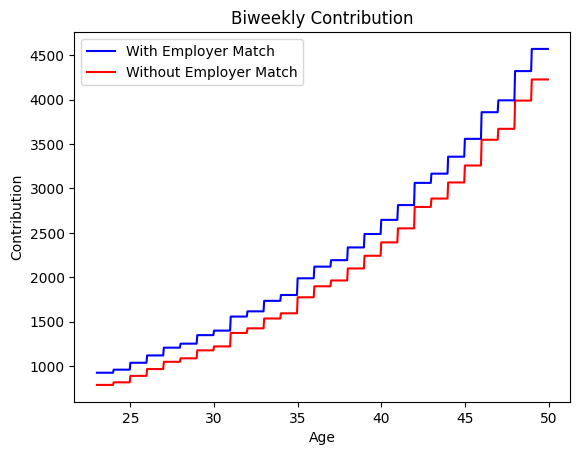

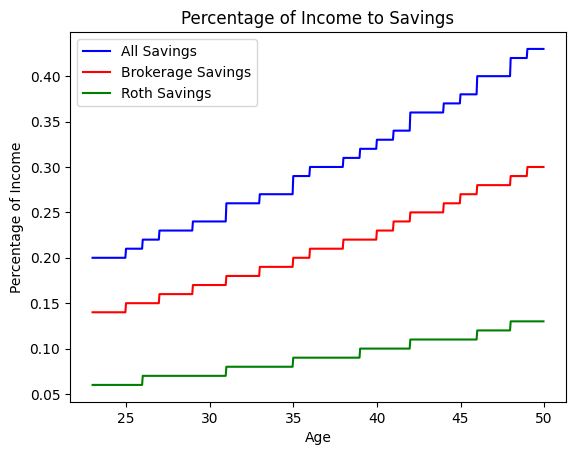

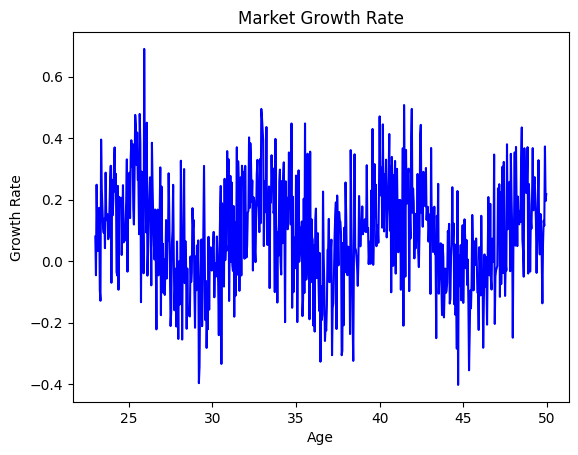

In [4]:
# Reformat from biweekly to yearly timespan
years_range = list(map(lambda x: x / 26, range(current_age * 26, current_age * 26 + len(balance_all))))

# Plot net worth
plt.plot(years_range, balance_all, 'b', label='Total Net Worth', zorder=2)
plt.plot(years_range, balance_income, 'r', label='Net Worth From Contributions', zorder=1)
plt.plot(years_range, starting_capital, 'g', label='Starting Capital', zorder=0)
plt.ticklabel_format(axis='y', style='plain')
plt.title("Net Worth by " + str(retirement_age))
plt.xlabel('Age')
plt.ylabel('Net Worth')
plt.legend(loc='upper left')
plt.show()

# Print safe retirement withdrawal using 4% rule
print("Safe monthly withdrawal after retirement using 4% rule: \033[1m" + str(round(retirement_withdrawal_safe, 2)) + "\033[0m\n"
      "After capital gains tax: \033[1m" + str(round(post_capital_gains_withdrawal_safe, 2)) + "\033[0m\n")

# Print maximum retirement withdrawal to maintain new worth
print("Maximum monthly withdrawal after retirement to maintin net worth: \033[1m" + str(round(retirement_withdrawal_max, 2)) + "\033[0m\n"
      "After capital gains tax: \033[1m" + str(round(post_capital_gains_withdrawal_max, 2)) + "\033[0m\n")

# Print age interest exceeds income
print("Age that investment interest exceeds income: \033[1m" + str(age_interest_exceed_income) + "\033[0m")

# Plot biweekly contribution
plt.plot(years_range, contribution_amount, 'b', label='With Employer Match', zorder=1)
plt.plot(years_range, contribution_amount_no_match, 'r', label='Without Employer Match', zorder=0)
plt.ticklabel_format(axis='y', style='plain')
plt.title("Biweekly Contribution")
plt.xlabel('Age')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

# Plot percentage of income to savings
plt.plot(years_range, [a + b for a, b in zip(savings_percentage_brokerage, savings_percentage_roth)], 'b', label='All Savings', zorder=2)
plt.plot(years_range, savings_percentage_brokerage, 'r', label='Brokerage Savings', zorder=1)
plt.plot(years_range, savings_percentage_roth, 'g', label='Roth Savings', zorder=0)
plt.ticklabel_format(axis='y', style='plain')
plt.title("Percentage of Income to Savings")
plt.xlabel('Age')
plt.ylabel('Percentage of Income')
plt.legend(loc='upper left')
plt.show()

# Plot market growth - Used in noisy market
plt.plot(years_range, market_rate, 'b')
plt.ticklabel_format(axis='y', style='plain')
plt.title("Market Growth Rate")
plt.xlabel('Age')
plt.ylabel('Growth Rate')
plt.show()